In [121]:
import matplotlib.pyplot as plt
import numpy as np
import random

from hmatrix import *
from collections import deque

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]
plt.style.use('default')

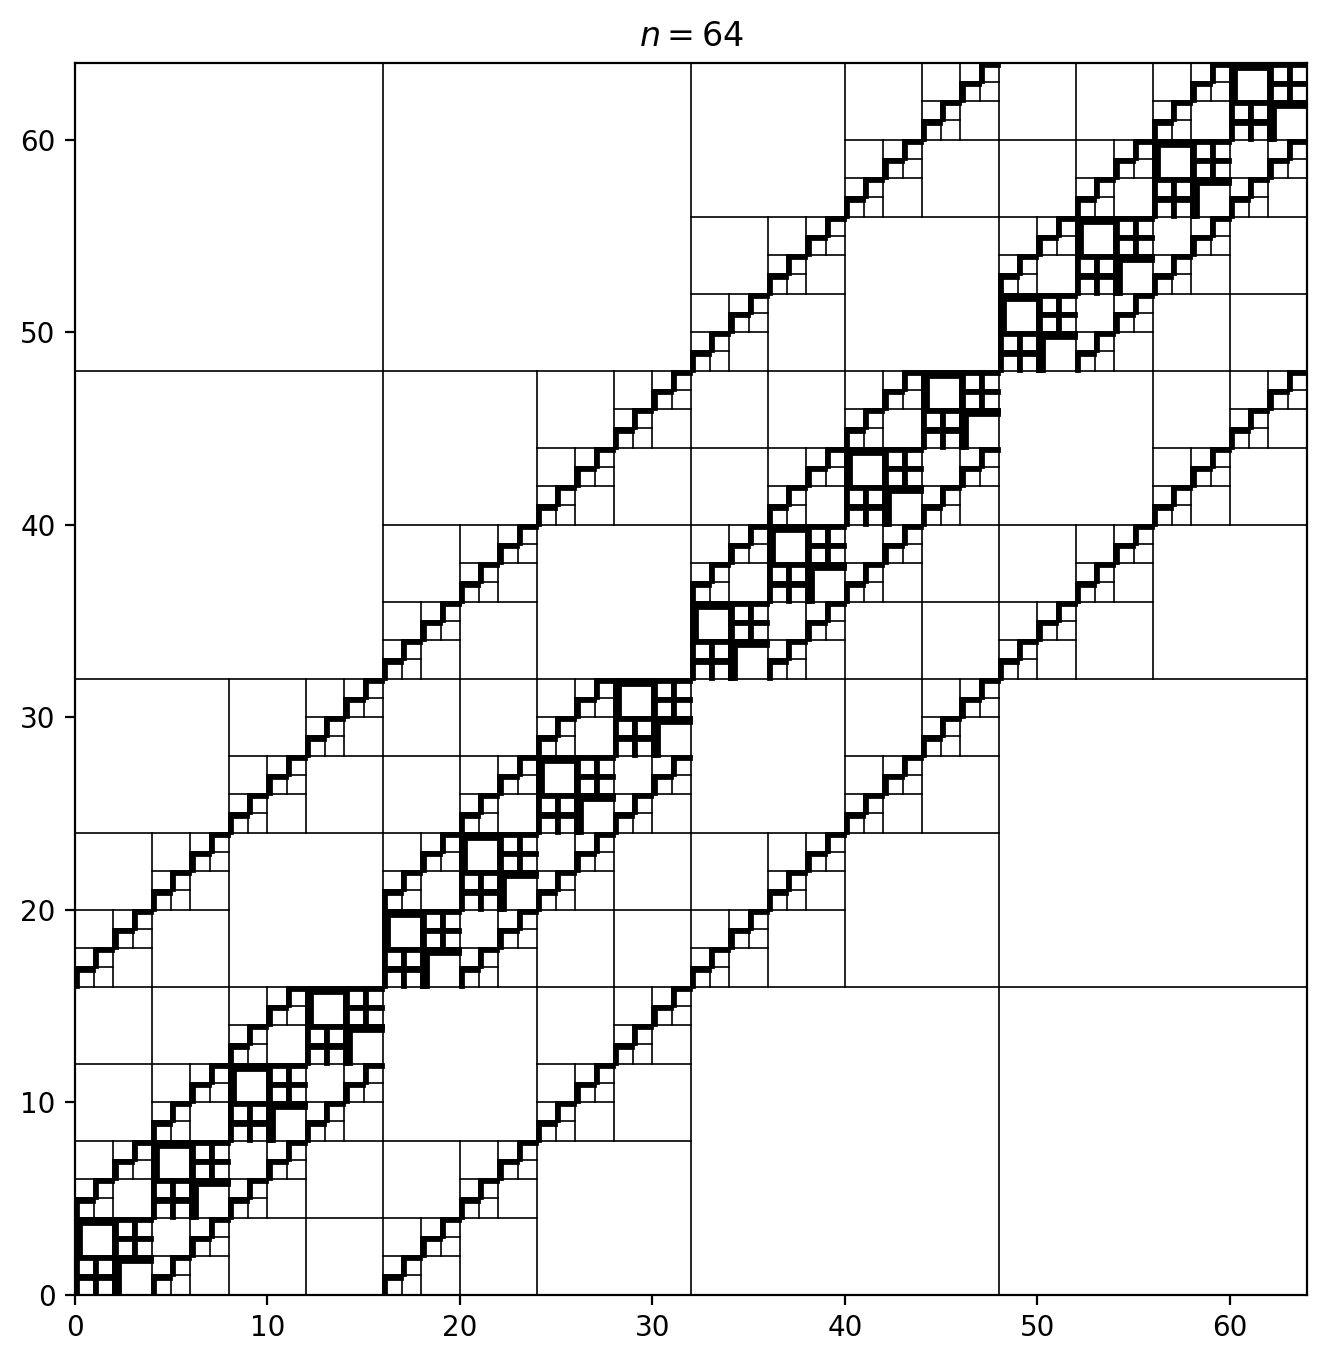

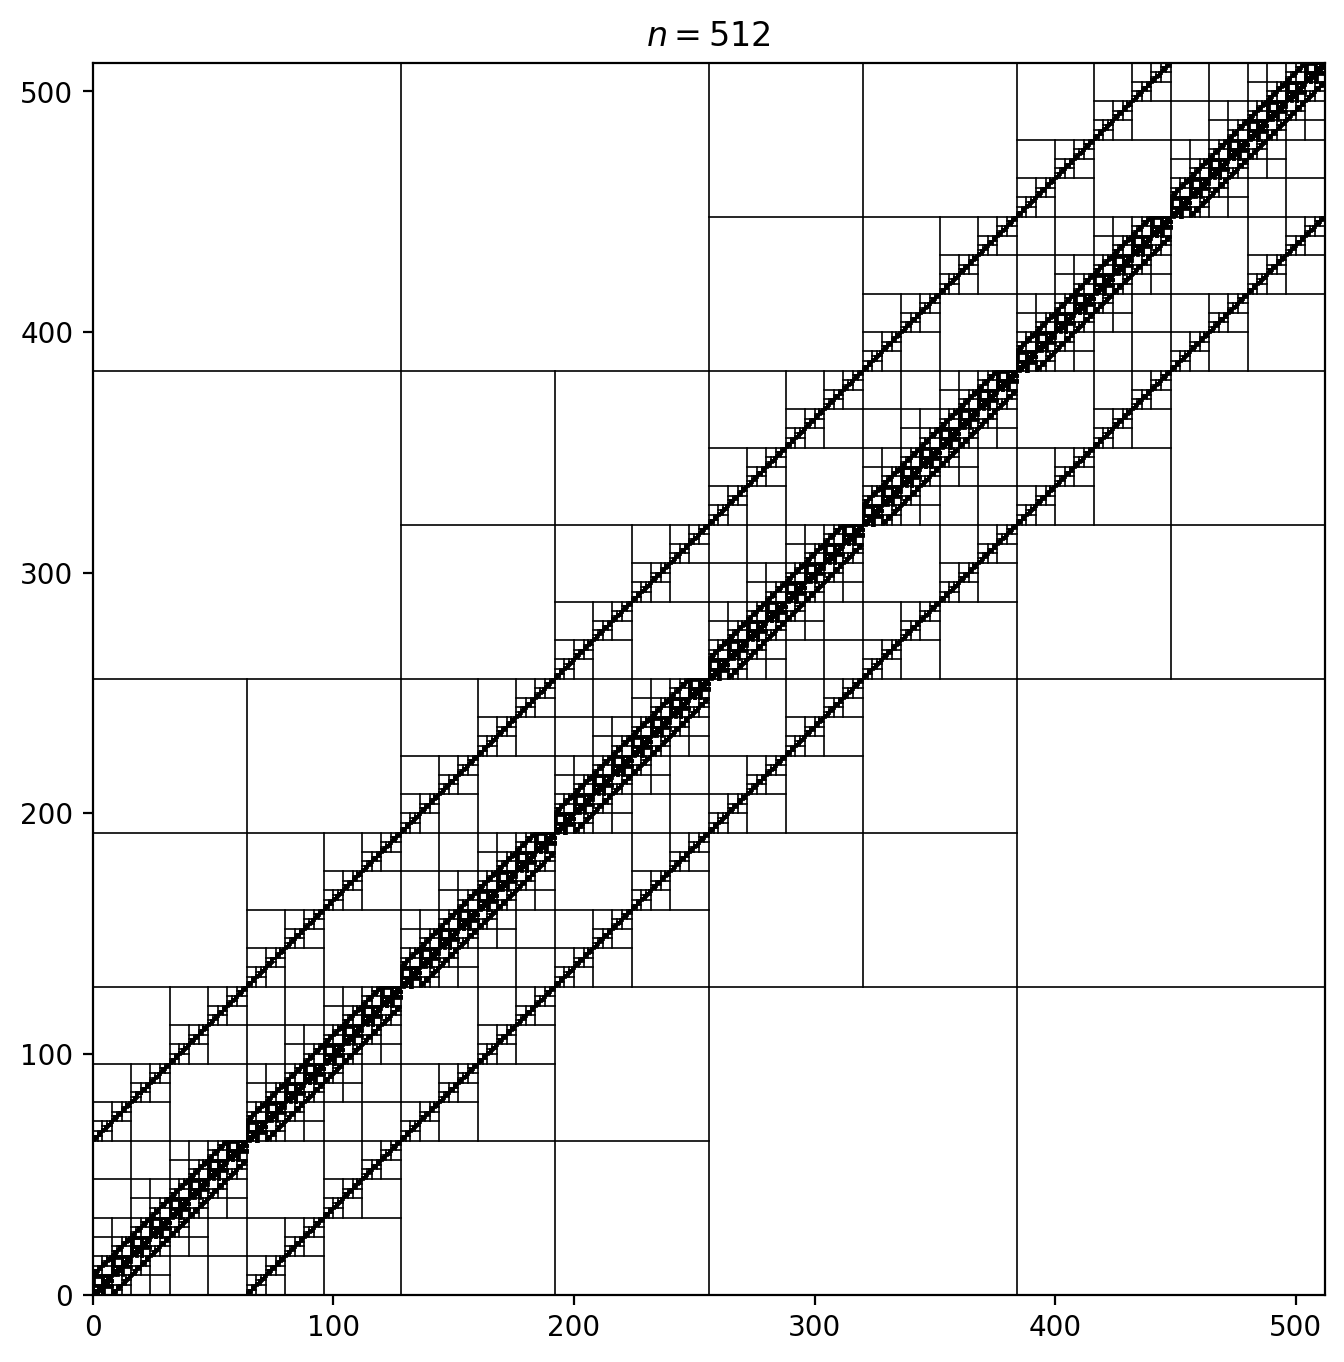

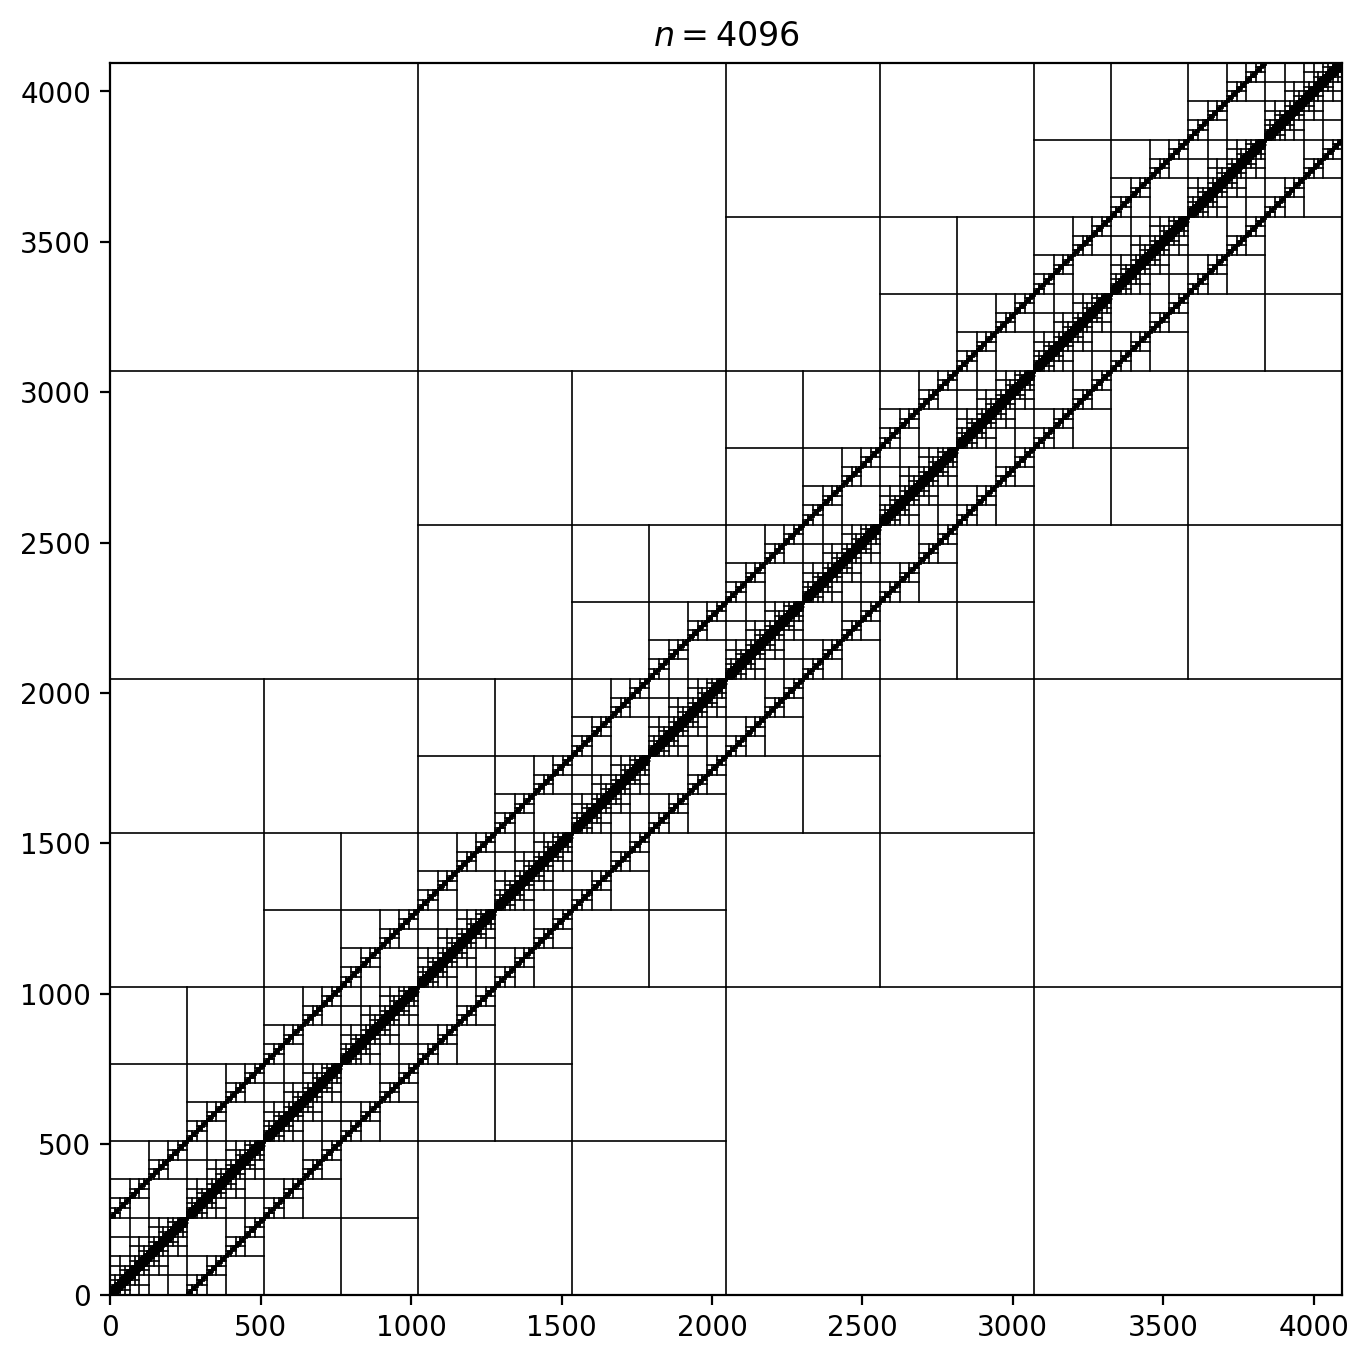

In [2]:
As = []

for w in (4, 8, 16):
    A = np.zeros((w**3, w**3))
    ind = lambda i, j, k: i + w * j + w**2 * k
    for i in range(w):
        for j in range(w):
            for k in range(w):
                A[ind(i, j, k), ind(i, j, k)] = random.random()
                if i - 1 >= 0:
                    A[ind(i, j, k), ind(i - 1, j, k)] = random.random()
                if i + 1 < w:
                    A[ind(i, j, k), ind(i + 1, j, k)] = random.random()
                if j - 1 >= 0:
                    A[ind(i, j, k), ind(i, j - 1, k)] = random.random()
                if j + 1 < w:
                    A[ind(i, j, k), ind(i, j + 1, k)] = random.random()
                if k - 1 >= 0:
                    A[ind(i, j, k), ind(i, j, k - 1)] = random.random()
                if k + 1 < w:
                    A[ind(i, j, k), ind(i, j, k + 1)] = random.random()
    As.append(A)

for i, A in enumerate(As):
    DrawTree(CreateTree(A, r=1, eps=1e-3)).savefig(f"{i}_bp_hm.png")

In [93]:
def mvmult(v: Node, X: np.ndarray, rev=False) -> np.ndarray:
    if not v.next:
        if v.rank == 0:
            return np.zeros(X.shape)
        if rev:
            return X @ v.U @ np.diag(v.D) @ v.V
        return v.U @ np.diag(v.D) @ v.V @ X

    k = X.shape[1] if rev else X.shape[0]
    X1 = X[:, : k // 2] if rev else X[: k // 2, :]
    X2 = X[:, k // 2 :] if rev else X[k // 2 :, :]

    Y11 = mvmult(v.next[0], X1, rev)
    Y12 = mvmult(v.next[2 if rev else 1], X2, rev)
    Y21 = mvmult(v.next[1 if rev else 2], X1, rev)
    Y22 = mvmult(v.next[3], X2, rev)

    return np.hstack((Y11 + Y12, Y21 + Y22)) if rev else np.vstack((Y11 + Y12, Y21 + Y22))


def mmmult(v: Node, w: Node) -> np.ndarray:
    zstack = lambda a, b, c, d: np.vstack((np.hstack((a, b)), np.hstack((c, d))))

    if v.rank == 0 or w.rank == 0:
        return np.zeros((v.side, w.side))

    if not v.next and not w.next:
        return v.U @ np.diag(v.D) @ v.V @ w.U @ np.diag(w.D) @ w.V

    if v.next and w.next:
        a1, a2, a3, a4 = v.next
        b1, b2, b3, b4 = w.next
        return zstack(
            mmmult(a1, b1) + mmmult(a2, b3),
            mmmult(a1, b2) + mmmult(a2, b4),
            mmmult(a3, b1) + mmmult(a4, b3),
            mmmult(a3, b2) + mmmult(a4, b4),
        )

    if not v.next and w.next:
        k = v.side
        b1, b2, b3, b4 = w.next
        U, V = v.U @ np.diag(v.D), v.V
        A1 = U[: k // 2, :] @ V[:, : k // 2]
        A2 = U[: k // 2, :] @ V[:, k // 2 :]
        A3 = U[k // 2 :, :] @ V[:, : k // 2]
        A4 = U[k // 2 :, :] @ V[:, k // 2 :]

        return zstack(
            mvmult(b1, A1, rev=True) + mvmult(b3, A2, rev=True),
            mvmult(b2, A1, rev=True) + mvmult(b4, A2, rev=True),
            mvmult(b1, A3, rev=True) + mvmult(b3, A4, rev=True),
            mvmult(b2, A3, rev=True) + mvmult(b4, A4, rev=True),
        )

    if v.next and not w.next:
        k = w.side
        a1, a2, a3, a4 = v.next
        U, V = w.U @ np.diag(w.D), w.V
        B1 = U[: k // 2, :] @ V[:, : k // 2]
        B2 = U[: k // 2, :] @ V[:, k // 2 :]
        B3 = U[k // 2 :, :] @ V[:, : k // 2]
        B4 = U[k // 2 :, :] @ V[:, k // 2 :]

        return zstack(
            mvmult(a1, B1) + mvmult(a2, B3),
            mvmult(a1, B2) + mvmult(a2, B4),
            mvmult(a3, B1) + mvmult(a4, B3),
            mvmult(a3, B2) + mvmult(a4, B4),
        )

In [127]:
# Check correctness
for A in As:
    v = CreateTree(A, r=1, eps=1e-3)
    X = np.random.random((A.shape[0], 1))
    print(np.allclose(A @ X, mvmult(v, X, rev=False)))
    print(np.allclose(X.T @ A, mvmult(v, X.T, rev=True)))

for A in As:
    v = CreateTree(A, r=1, eps=1e-3)
    print(np.allclose(A @ A, mmmult(v, v)))

True
True
True
True
True
True
True
True
True


In [98]:
for _ in range(25):
    k = 6
    A = np.random.random((2**k, 2**k))
    v = CreateTree(A, r=1, eps=1e-3)
    X = np.random.random((A.shape[0], 1))
    
    assert np.allclose(A @ X, mvmult(v, X, rev=False))
    assert np.allclose(X.T @ A, mvmult(v, X.T, rev=True))
    assert np.allclose(A @ A, mmmult(v, v))

In [104]:
from time import perf_counter

mvTimes = []
for A in As:
    v = CreateTree(A, r=1, eps=1e-3)
    X = np.random.random((A.shape[0], 1))
    s = perf_counter()
    AX = mvmult(v, X)
    e = perf_counter()

    assert np.allclose(AX, A @ X)
    mvTimes.append(e - s)

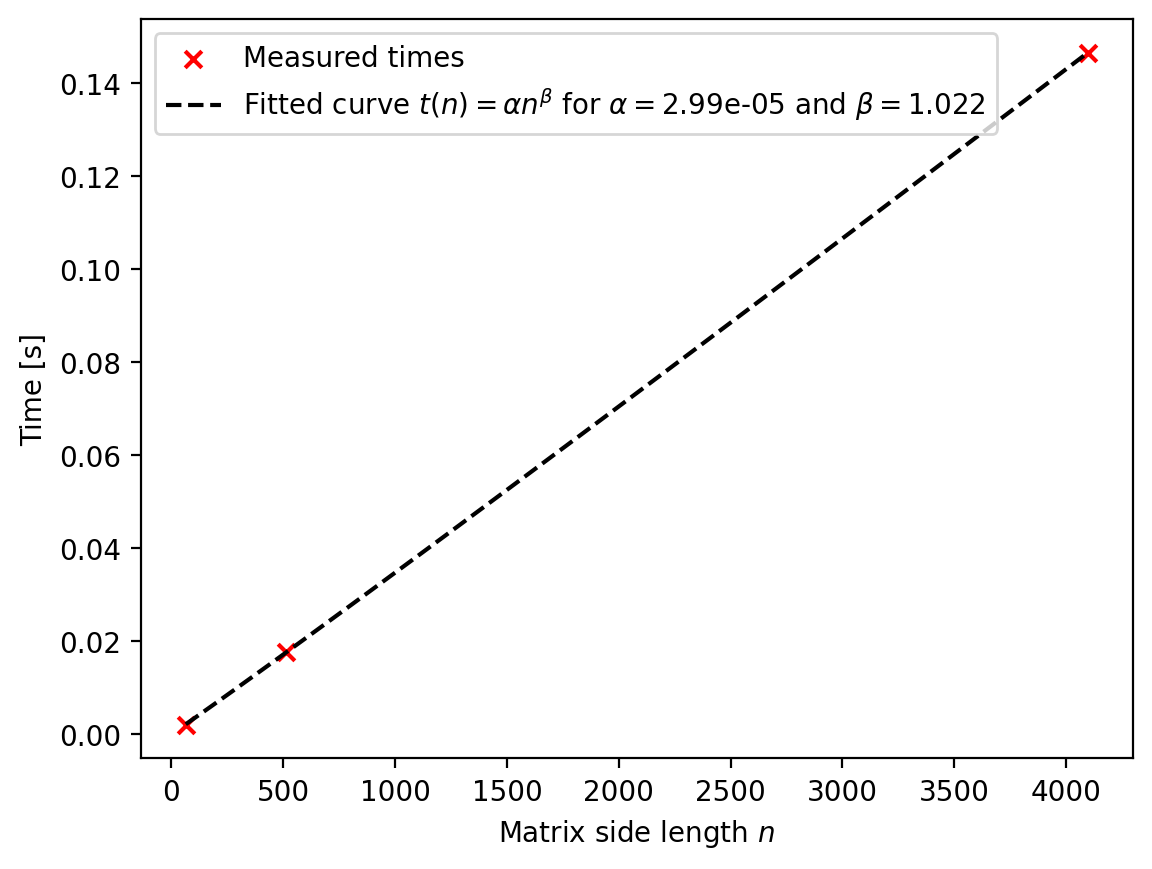

In [125]:
from scipy.optimize import curve_fit

f = lambda x, a, b: a * x**b
coeff, _ = curve_fit(f, [2 ** (3 * k) for k in (2, 3, 4)], mvTimes)
a, b = coeff
f_app = lambda x: f(x, a, b)

plt.scatter(
    [2 ** (3 * k) for k in (2, 3, 4)],
    mvTimes,
    marker="x",
    color="r",
    label="Measured times",
)
plt.plot(
    np.linspace(64, 4096, 100),
    f_app(np.linspace(64, 4096, 100)),
    color="k",
    ls="--",
    label=r"Fitted curve $t(n) = \alpha n^\beta$"
    + r" for $\alpha=$"
    + f"{a:.2e}"
    + r" and $\beta=$"
    + f"{b:.3f}",
)
plt.xlabel(r"Matrix side length $n$")
plt.ylabel("Time [s]")
plt.legend(loc="best")
plt.savefig("mvtimes.png", dpi=500)

In [101]:
mmTimes = []
for A in As:
    v = CreateTree(A, r=1, eps=1e-3)
    s = perf_counter()
    AA = mmmult(v, v)
    e = perf_counter()
    assert np.allclose(AA, A @ A)
    mmTimes.append(e - s)

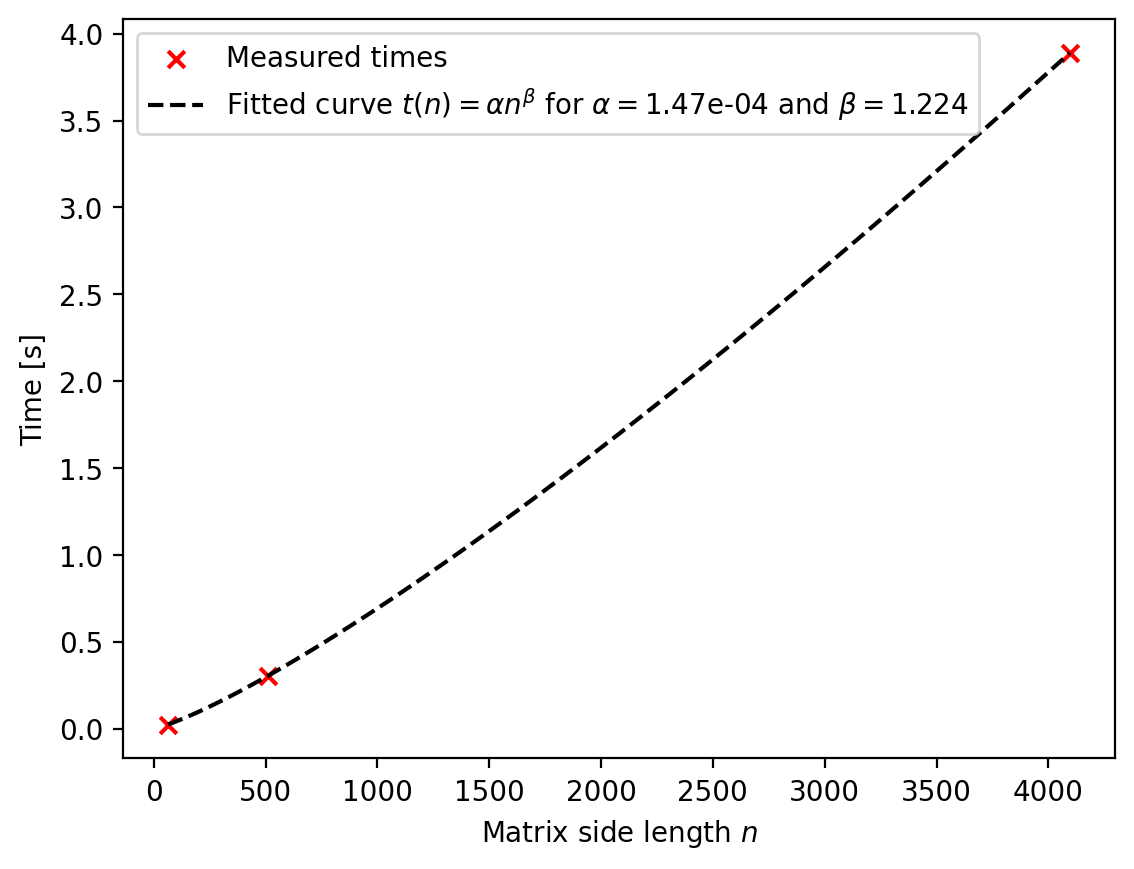

In [126]:
f = lambda x, a, b: a * x**b
coeff, _ = curve_fit(f, [2 ** (3 * k) for k in (2, 3, 4)], mmTimes)
a, b = coeff
f_app = lambda x: f(x, a, b)

plt.scatter(
    [2 ** (3 * k) for k in (2, 3, 4)],
    mmTimes,
    marker="x",
    color="r",
    label="Measured times",
)
plt.plot(
    np.linspace(64, 4096, 100),
    f_app(np.linspace(64, 4096, 100)),
    color="k",
    ls="--",
    label=r"Fitted curve $t(n) = \alpha n^\beta$"
    + r" for $\alpha=$"
    + f"{a:.2e}"
    + r" and $\beta=$"
    + f"{b:.3f}",
)
plt.xlabel(r"Matrix side length $n$")
plt.ylabel("Time [s]")
plt.legend(loc="best")
plt.savefig("mmtimes.png", dpi=500)